In [1]:
# binder https://hub.gke.mybinder.org/user/blychs-climatologia_fisica-dckeuhha/notebooks/practica2.ipynb
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import copy
from metpy.units import units
import metpy.calc as mpcalc
import metpy.constants as mpconsts
import datetime as dt
import calendar
import seaborn as sns
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
#from funciones_meteo import load_file, ploteo_general, calculate_h

In [2]:
import funciones_meteo as fm

In [3]:
# Datos de reanalisis
pres_r = fm.load_file('reanalysis/pl.mon.mean.nc')
tmp_r  = fm.load_file('reanalysis/tmp.mon.mean.nc')
hum_r  = fm.load_file('reanalysis/rhum.mon.mean.nc')

# Datos del modelo CMIP5
t_c5_hist     = fm.load_file('NorESM1-M/tas_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc')
t_c5_26_close = fm.load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc')
t_c5_26_far   = fm.load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc')
t_c5_85_close = fm.load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc')
t_c5_85_far   = fm.load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc')

h_c5_hist     = fm.load_file('NorESM1-M/huss_Amon_NorESM1-M_historical_r*_197601-200512_2.5_anu.nc')
h_c5_26_close = fm.load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_202001-204912_2.5_anu.nc')
h_c5_26_far   = fm.load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_207001-209912_2.5_anu.nc')
h_c5_85_close = fm.load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_202001-204912_2.5_anu.nc')
h_c5_85_far   = fm.load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_207001-209912_2.5_anu.nc')

#Datos del modelo CMIP6
t_c6_hist      = fm.load_file('NorESM2-LM/tas_Amon_NorESM2-LM_historical_r*_2.5.nc')
t_c6_126_close = fm.load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
t_c6_126_far   = fm.load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
t_c6_585_close = fm.load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
t_c6_585_far   = fm.load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

h_c6_hist      = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_historical_r*_2.5.nc')
h_c6_126_close = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
h_c6_126_far   = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
h_c6_585_close = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
h_c6_585_far   = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

h_c6_hist      = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_historical_r*_2.5.nc')
h_c6_126_close = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
h_c6_126_far   = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
h_c6_585_close = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
h_c6_585_far   = fm.load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

{'ds': <xarray.Dataset>
Dimensions:  (lat: 73, lon: 145, time: 372)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * time     (time) datetime64[ns] 1975-01-01 1975-02-01 ... 2005-12-01
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 352.5 355.0 357.5 360.0
Data variables:
    rhum     (time, lat, lon) float32 dask.array<chunksize=(372, 73, 144), meta=np.ndarray>, 'mean': <xarray.Dataset>
Dimensions:  (lat: 73, lon: 145)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 352.5 355.0 357.5 360.0
Data variables:
    rhum     (lat, lon) float32 dask.array<chunksize=(73, 144), meta=np.ndarray>}


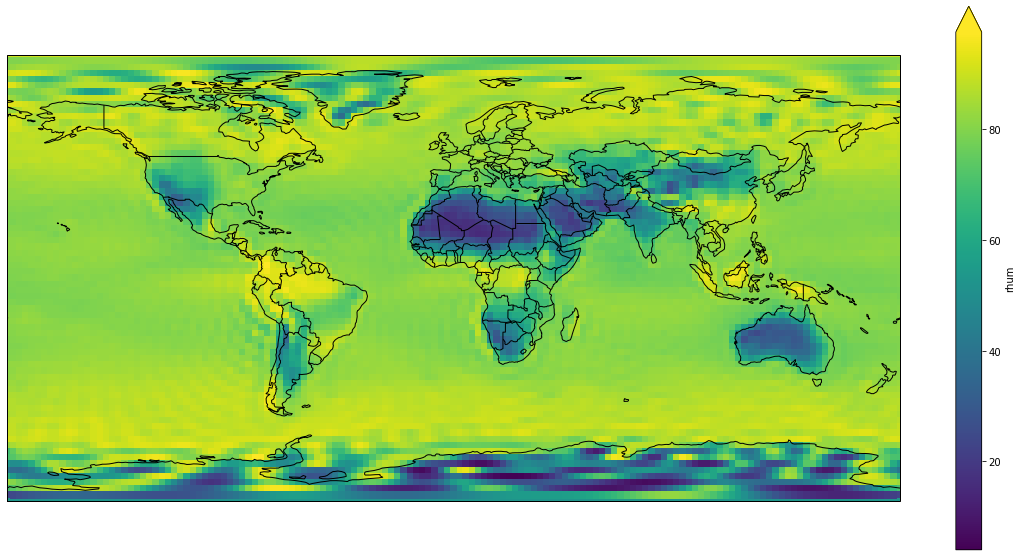

In [11]:
print(hum_r)
fm.ploteo_general(hum_r['mean'].rhum)